# Stock Price Prediction using Linear Regression

> Source: [Medium Article](https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001)

In this notebook, we are currently using the stock `VTI`

In [1]:
import pandas_datareader.data as web
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import date, datetime, time, timedelta

In [2]:
start = datetime(2015, 11, 25)
end = datetime(2018, 11, 23)
stock_ticker = 'VTI'
data = web.DataReader(stock_ticker, 'yahoo', start, end)
data.columns = [str(x).lower().replace(' ', '-') for x in data.columns]
data['month'] = data.index.values.astype('datetime64[M]').astype(int) % 12 + 1
data.head(10)

,high,low,open,close,volume,adj-close,month
Date,,,,,,,
2015-11-25,107.660004,107.250000,107.510002,107.470001,1820300.0,99.990135,11
2015-11-27,107.760002,107.220001,107.589996,107.629997,552400.0,100.139000,11
2015-11-30,107.849998,107.110001,107.779999,107.169998,3618100.0,99.711006,11
2015-12-01,108.209999,107.370003,107.589996,108.180000,2443600.0,100.650711,12
2015-12-02,108.269997,106.879997,108.099998,107.050003,2937200.0,99.599350,12
2015-12-03,107.480003,105.059998,107.290001,105.449997,3345600.0,98.110725,12
2015-12-04,107.540001,105.620003,105.809998,107.389999,4520000.0,99.915688,12
2015-12-07,107.269997,106.059998,107.230003,106.550003,3000500.0,99.134171,12
2015-12-08,106.400002,105.269997,105.940002,105.910004,3149600.0,98.538704,12


## What is Linear Regression ?

It is an approach where we would model the relationship between the `dependent` variable and one or more `independent` variables using a linear equation. Here we will fit a linear regression model to the previous $N$ values, and use this model to predict the value on the current day.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Prediction Model using the Linear Regression

In [4]:
test_size = 0.2
cv_size = 0.2
Nmax = 30 # For feature at day `n`, we use lags from n-1, n-2, ..., n-N as features

def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
        Given a dataframe, predict the stock price on day n using stock prices from n-1, n-2, ... , n-N
        
        Params
        -------
            data: dataframe with values that needs to be predicted.
            target_col: Name of the column you want to predict e.g. `adj-close`
            N: Number of previous day stock prices to consider to predict the current day price
            pred_min: The lowest stock price to correct the price of a stock prediction to
            offset: On the data, we predict prices on data[offset:] e.g. offset can be the size of the training data
        Outputs
        -------
            preds_list: the predictions for target_col. np.array of length : len(df) - offset
    """
    lin_reg = LinearRegression(fit_intercept=True)
    preds_list = list()
    
    for i in range(offset, len(df[target_col])):
        X_train = np.array(range(len(data[target_col][i-N:i])))
        y_train = np.array(data[target_col][i-N:i])
        X_train = X_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        lin_reg.fit(X_train, y_train)
        pred = lin_reg.predict(np.array(N).reshape(-1, 1))
        preds_list.append(pred[0][0])
    preds_list = np.array(preds_list)
    preds_list[preds_list < pred_min] = pred_min
    return preds_list

def get_mape(y_true, y_pred):
    """
        Compute Mean Absolute Percentage Error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Split the dataset into Training, Validation and Testing datasets
We will split the dataset into $60\%$ training, $20\%$ validation and $20\%$ testing dataset. The prediction model will be trained using the training dataset, model hyperparameters will be tuned using the validation set, and finally the performance of the model will be evaluated using the test dataset.

In [5]:
num_cv = int(cv_size * len(data))
num_test = int(test_size * len(data))
num_train = len(data) - num_cv - num_test

# TODO: Replace these below methods to use train_test_split method from sklearn.model_selection
train = data[:num_train]
cv = data[num_train:num_train + num_cv]
train_cv = data[:num_train + num_cv]
test = data[num_train + num_cv:]

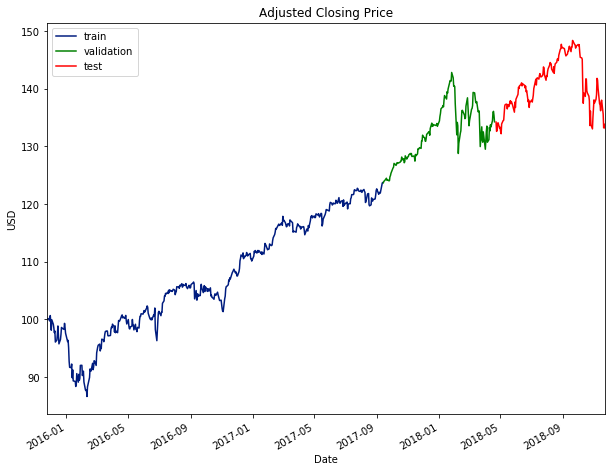

In [6]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-dark-palette')
ax = train['adj-close'].plot()
ax = cv['adj-close'].plot(color='g', ax=ax)
ax = test['adj-close'].plot(color='r', ax=ax)
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price')
ax.legend(['train', 'validation', 'test'])

# Predict using the Linear Regression

In [7]:
RMSE = list()
R2 = list()
mape = list()

# N is the no. of samples to use to predict the next value
for N in range(1, Nmax+1):
    est_list = get_preds_lin_reg(train_cv, 'adj-close', N, 0, num_train)
    cv['est_N{}'.format(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj-close'])))
    R2.append(r2_score(cv['adj-close'], est_list))
    mape.append(get_mape(cv['adj-close'], est_list))
cv.head()

/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,high,low,open,close,volume,adj-close,month,est_N1,est_N2,est_N3,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-14,128.479996,128.070007,128.229996,128.360001,1493200.0,123.672958,9,123.711510,123.769325,124.045525,...,123.116395,122.955610,122.924459,122.907976,122.741857,122.588263,122.430840,122.312924,122.228832,122.136642
2017-09-15,128.619995,128.199997,128.309998,128.600006,1531300.0,123.904221,9,123.672958,123.634407,123.698652,...,123.532070,123.362024,123.203829,123.168778,123.147964,122.983527,122.830316,122.672777,122.552808,122.465266
2017-09-18,129.100006,128.690002,128.850006,128.910004,1792300.0,124.202881,9,123.904221,124.135483,123.955607,...,123.986333,123.772948,123.607354,123.451821,123.413503,123.388964,123.226307,123.073697,122.916300,122.794668
2017-09-19,129.100006,128.850006,129.059998,128.970001,1241700.0,124.260712,9,124.202881,124.501541,124.456609,...,124.255511,124.231165,124.025347,123.863536,123.710255,123.668789,123.640660,123.479507,123.327348,123.170006
2017-09-20,129.210007,128.600006,129.100006,129.179993,1729200.0,124.463036,9,124.260712,124.318542,124.479095,...,124.451743,124.467660,124.444332,124.246875,124.089968,123.940138,123.897071,123.866815,123.708164,123.557486


### Plots of RMSE v/s N, R2 Score v/s N & MAPE v/s N

([<matplotlib.axis.XTick at 0x7f2a13ab08d0>,
 <a list of 8 Text xticklabel objects>)

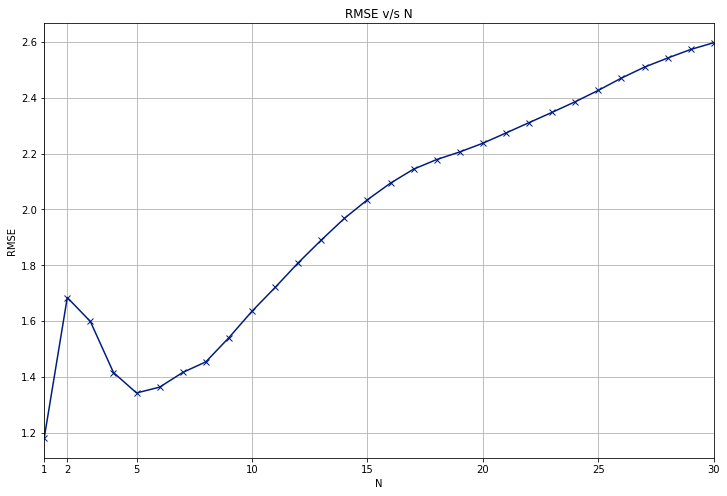

In [8]:
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-dark-palette')
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.title('RMSE v/s N')
plt.xlim([1, Nmax])
plt.xticks([1, 2] + [val for val in range(5, Nmax+1, 5)])

([<matplotlib.axis.XTick at 0x7f2a1429a898>,
 <a list of 8 Text xticklabel objects>)

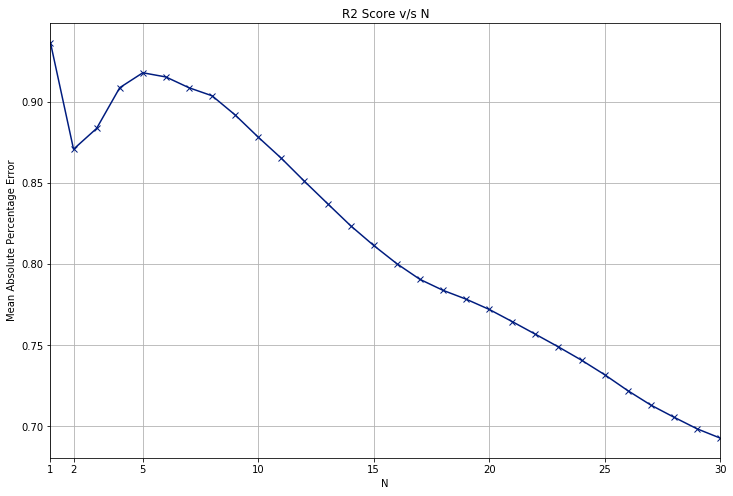

In [9]:
# Plot MAPE versus N
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-dark-palette')
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('R2 Score v/s N')
plt.xlim([1, Nmax])
plt.xticks([1, 2] + [val for val in range(5, Nmax+1, 5)])

([<matplotlib.axis.XTick at 0x7f2a14280cc0>,
 <a list of 7 Text xticklabel objects>)

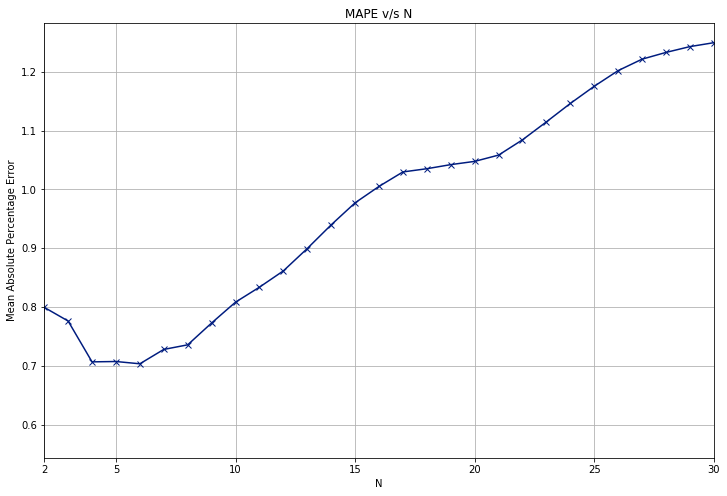

In [10]:
# Plot MAPE versus N
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-dark-palette')
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('MAPE v/s N')
plt.xlim([2, Nmax])
plt.xticks([2] + [val for val in range(5, Nmax+1, 5)])

In [11]:
# +1 is added because the N value starts from 1. 
# we are ignoring the value of N=1, because we will be just using the Previous day's value
N_opt = np.argmin(np.array(mape[1:]), axis=0) + 1
print("Optimal previous days data to use to predict current day's price is {}".format(N_opt))

Optimal previous days data to use to predict current day's price is 5


### Plot the prediction on validation set

Text(0.5, 1.0, 'Adjusted Closing Price')

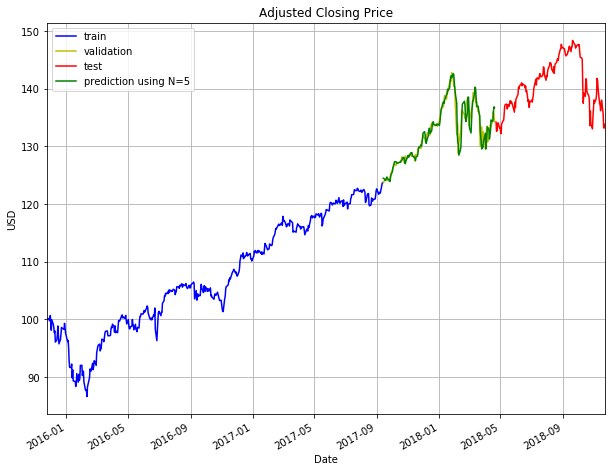

In [12]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-dark-palette')
ax = train['adj-close'].plot(style='b-', grid=True)
ax = cv['adj-close'].plot(style='y-', grid=True, ax=ax)
ax = test['adj-close'].plot(style='r-', grid=True, ax=ax)
ax = cv['est_N{}'.format(N_opt)].plot(style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'prediction using N={}'.format(N_opt)])
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price')

### Zoom into the Prediction on the Validation Set

Text(0.5, 1.0, 'Adjusted Closing Price')

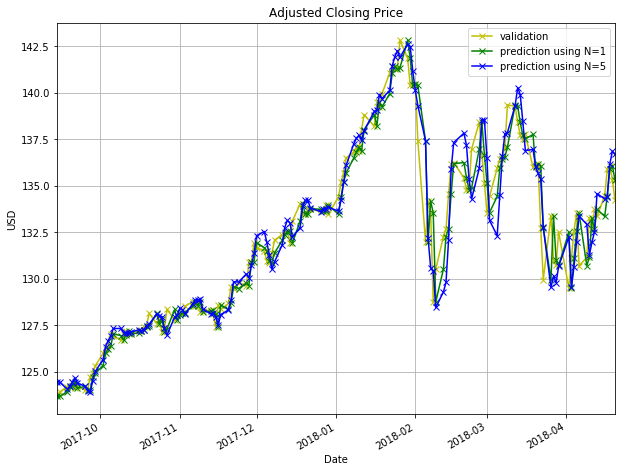

In [13]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-dark-palette')
ax = cv['adj-close'].plot(style='yx-', grid=True)
ax = cv['est_N1'].plot(style='gx-', grid=True, ax=ax)
ax = cv['est_N{}'.format(N_opt)].plot(style='bx-', grid=True, ax=ax)
ax.legend(['validation', 'prediction using N=1', 'prediction using N={}'.format(N_opt)])
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price')

## Final Model

In [14]:
# Making the Predictions on Test Dataset
est_list = get_preds_lin_reg(data, 'adj-close', N_opt, 0, num_train+num_cv)
test['est_N{}'.format(N_opt)] = est_list
print("RMSE = {0:.3f}".format(math.sqrt(mean_squared_error(est_list, test['adj-close']))))
print("R2 Score = {0:.3f}".format(r2_score(test['adj-close'], est_list)))
print("MAPE = {0:.3f}%".format(get_mape(test['adj-close'], est_list)))
test.head()

RMSE = 1.399
R2 Score = 0.900
MAPE = 0.707%


/home/mbgorantla/Documents/Python/SR_ML_Portfolio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,high,low,open,close,volume,adj-close,month,est_N5
Date,,,,,,,,
2018-04-23,138.160004,136.809998,137.779999,137.449997,2033700.0,134.196945,4,134.896994
2018-04-24,138.190002,134.860001,138.100006,135.800003,3053500.0,132.586014,4,133.587721
2018-04-25,136.250000,134.610001,135.770004,135.949997,2275400.0,132.732452,4,132.059767
2018-04-26,137.679993,136.250000,136.520004,137.240005,1284600.0,133.991913,4,131.765875
2018-04-27,137.740005,136.800003,137.539993,137.330002,1133600.0,134.079803,4,132.958955


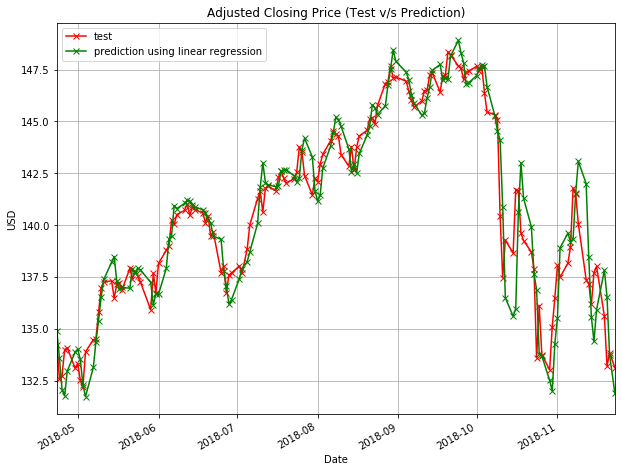

In [15]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-dark-palette')
ax = test['adj-close'].plot(style='rx-', grid=True)
ax = test['est_N{}'.format(N_opt)].plot(style='gx-', grid=True, ax=ax)
ax.set_ylabel('USD')
ax.set_title('Adjusted Closing Price (Test v/s Prediction)')
ax.legend(['test', 'prediction using linear regression'])